In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import zscore

# Loading Dataset

Dataset is read and the **BasketDate** is converted 'str' to 'datetime'. Added **TotalSale** feature which is useful for some additional features related to customer's purchasing behavior.

In [28]:
dataset_frame = pd.read_csv('Data/customer_supermarket.csv', sep='\t', index_col=0, decimal=',')
dataset_frame['BasketDate'] = pd.to_datetime(dataset_frame['BasketDate'], dayfirst=True)
dataset_frame['TotalSale'] = dataset_frame['Sale'] * dataset_frame['Qta']
dataset_frame.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  object        
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
 8   TotalSale        471910 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 36.0+ MB


Count of null values, for each attribute

In [29]:
dataset_frame.isnull().sum(axis = 0)

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
TotalSale              0
dtype: int64

# Analysis of Single Attributes

***BasketID***

Count number of distinct baskets

In [30]:
basketID_counts = dataset_frame['BasketID'].value_counts()
basketID_counts.describe()

count    24627.000000
mean        19.162302
std         28.635400
min          1.000000
25%          2.000000
50%         11.000000
75%         24.000000
max        542.000000
Name: BasketID, dtype: float64

***BasketDate***

Statistics on BasketDate

In [31]:
basketDate_counts = dataset_frame['BasketDate'].dt.date.value_counts()
print("Max date: ", str(max(dataset_frame['BasketDate'])))
print("Min date: ", str(min(dataset_frame['BasketDate'])))
print("More sales:", str(basketDate_counts.index[0]))
print("Less sales:", str(basketDate_counts.index[-1]))

Max date:  2011-12-09 12:50:00
Min date:  2010-12-01 08:26:00
More sales: 2011-12-05
Less sales: 2010-12-22


[]

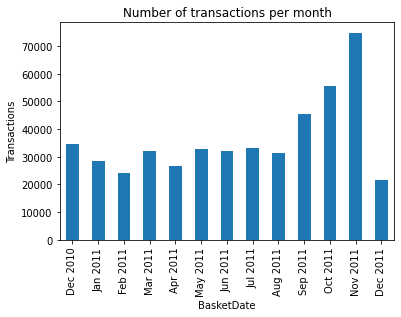

In [32]:
temp = dataset_frame.groupby(pd.Grouper(key='BasketDate', freq='M'))['BasketID'].count()
temp.index = temp.index.strftime('%b %Y')
aplt = temp.plot(kind='bar', title='Number of transactions per month', rot=90)
aplt.set_ylabel('Transactions')
aplt.plot()

***Sale***

Null cost sales

In [33]:
sale_cost_zero = dataset_frame['Sale'] == 0
dataset_frame[sale_cost_zero].count()

BasketID           1279
BasketDate         1279
Sale               1279
CustomerID           40
CustomerCountry    1279
ProdID             1279
ProdDescr           526
Qta                1279
TotalSale          1279
dtype: int64

***CustomerID***

Number of transactions made by each customer

count    4372.000000
mean       93.053522
std       232.471568
min         1.000000
25%        17.000000
50%        42.000000
75%       102.000000
max      7983.000000
Name: CustomerID, dtype: float64


Text(0, 0.5, 'Transactions')

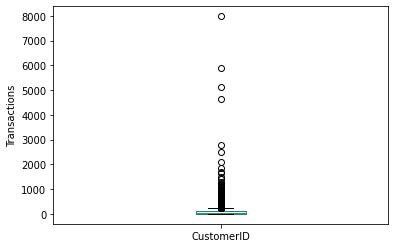

In [34]:
customerID_counts = dataset_frame['CustomerID'].value_counts()
print(customerID_counts.describe())
customer_id_plot = customerID_counts.plot.box()
customer_id_plot.set_ylabel("Transactions")



*   According to what we calculated above, there are 65080 null CustomerIDs. Therefore, transactions with null CustomerID are deleted.



In [35]:
#Drop null customerId
dataset_frame.dropna(subset=['CustomerID'], inplace=True)

***CustomerCountry***

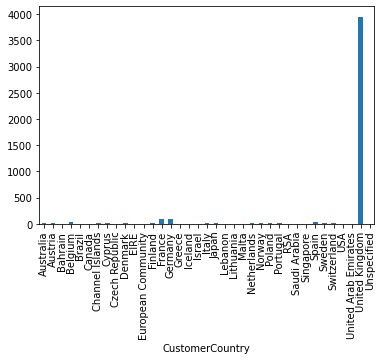

In [36]:
customerCountry_counts = dataset_frame.groupby(['CustomerCountry', 'CustomerID']).size().groupby(level=0).size()
customerCountry_counts.plot.bar()

As can be seen from the graph, United Kingdom has the highest number of customer countries.

***ProdID, ProdDescr***

In [37]:
prodID_counts = dataset_frame['ProdID'].value_counts()
print(prodID_counts.describe())

best_seller_id = prodID_counts.index[0]
best_seller_descr = dataset_frame.loc[dataset_frame['ProdID'] == best_seller_id]['ProdDescr'].iloc[0]
print("Best seller: {} ({})".format(str(best_seller_id), str(best_seller_descr)))

worst_seller_id = prodID_counts.index[-1]
worst_seller_descr = dataset_frame.loc[dataset_frame['ProdID'] == worst_seller_id]['ProdDescr'].iloc[0]
print("Worst seller: {} ({})".format(str(worst_seller_id), str(worst_seller_descr)))

count    3684.000000
mean      110.431596
std       167.529851
min         1.000000
25%        12.000000
50%        49.000000
75%       139.000000
max      2077.000000
Name: ProdID, dtype: float64
Best seller: 85123A (WHITE HANGING HEART T-LIGHT HOLDER)
Worst seller: 84773 (RED ROSE AND LACE C/COVER)


***Qta***

Negative quantity

In [38]:
negative_qta = dataset_frame['Qta'] < 0
dataset_frame[negative_qta].count()

BasketID           8905
BasketDate         8905
Sale               8905
CustomerID         8905
CustomerCountry    8905
ProdID             8905
ProdDescr          8905
Qta                8905
TotalSale          8905
dtype: int64

# Drop Transaction and Clean Dataset Export

In [20]:
dataset_frame[sale_cost_zero & negative_qta].count()

BasketID           668
BasketDate         668
Sale               668
CustomerID           0
CustomerCountry    668
ProdID             668
ProdDescr          221
Qta                668
TotalSale          668
dtype: int64

These transactions are dropped because they're not relevant for project purposes.

In [21]:
dataset_frame.drop(dataset_frame[negative_qta].index, inplace=True)
dataset_frame.drop(dataset_frame[sale_cost_zero].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Export clean dataset

In [22]:
dataset_frame.to_csv(r'Data/clean_dataset.csv', index=True, header=True)

# Correlation Analysis

***Original Dataset***

To calculate pairwise correlation, I transformed some attributes into categorical ones. Due to implementation reasons, ProdDescr had to be treated differently from other attributes. For this reason, I introduced a dictionary: for each string (key) we assigned an incremental identifier (value). Then I replaced all the descriptions with their associated identifier and this way I proceeded to calculate the pairwise correlation, represented by a heatmap.

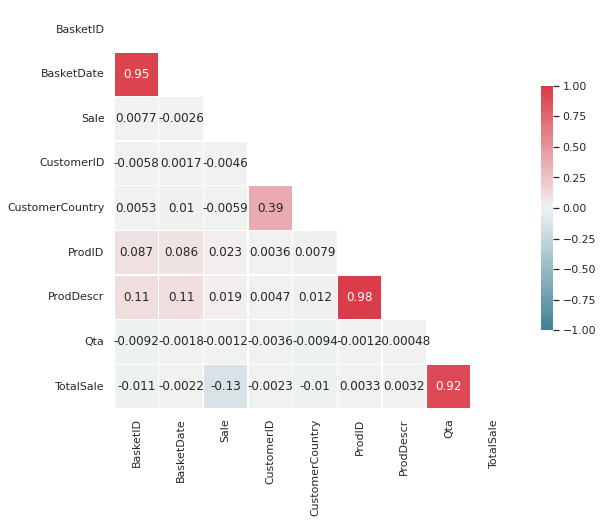

In [39]:
dataset_frame_correlation = dataset_frame.copy()
dataset_frame_correlation['ProdID'] = dataset_frame_correlation['ProdID'].astype('category').cat.codes
dataset_frame_correlation.sort_values(by=['ProdID'], inplace=True)
obj = {}
idx = 0
s = ""
for index, row in dataset_frame_correlation.iterrows():
    if row['ProdDescr'] != s:
        s = row['ProdDescr']
        obj[s] = idx
        idx += 1
dataset_frame_correlation['ProdDescr'].replace(obj, inplace=True)
dataset_frame_correlation['BasketID'] = dataset_frame_correlation['BasketID'].astype('category').cat.codes
dataset_frame_correlation['BasketDate'] = dataset_frame_correlation['BasketDate'].astype('category').cat.codes
dataset_frame_correlation['CustomerID'] = dataset_frame_correlation['CustomerID'].astype('category').cat.codes
dataset_frame_correlation['CustomerCountry'] = dataset_frame_correlation['CustomerCountry'].astype('category').cat.codes
correlation = dataset_frame_correlation.corr()
sns.set(style="white")
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(9,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1,center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

# New features

*   ObservationItems
*   ObservationDistinctItems
*   ObservationMaxItem



In [43]:
dataset_frame_customer = dataset_frame.groupby('CustomerID').agg(ObservationItems=('ProdID','count'),ObservationDistinctItems=('ProdID', 'nunique'))
dataset_frame_customer['ObservationMaxItem'] = dataset_frame.groupby(['CustomerID','BasketID']).count().max(level=0)['BasketDate']

*   BasketNum : Number of Baskets per customer.


In [45]:
dataset_frame_customer['BasketNum'] = dataset_frame.groupby(['CustomerID', 'BasketID']).size().groupby(level=0).size()

Sum and Average expenditure for each customer.

*   SumExp
*   AvgExp



In [48]:
dataset_frame_group = dataset_frame.groupby(['CustomerID','BasketID']).agg(BasketSum=('TotalSale', 'sum'))
dataset_frame_group = dataset_frame_group.groupby('CustomerID').agg(BasketMean=('BasketSum', 'mean'), SumExp=('BasketSum', 'sum'))
dataset_frame_customer['SumExp'] = dataset_frame_group['SumExp']
dataset_frame_customer['AvgExp'] = dataset_frame_group['BasketMean']

# Analysis of New Dataset

By combining the required features with the new ones, I created a new dataset useful for subsequent clustering tasks.

In [49]:
dataset_frame_customer.describe()

,ObservationItems,ObservationDistinctItems,ObservationMaxItem,BasketNum,SumExp,AvgExp
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,93.053522,61.211116,31.867795,5.075480,1898.463818,315.884437
std,232.471568,85.425119,31.225805,9.338754,8219.344627,361.237024
min,1.000000,1.000000,1.000000,1.000000,-4287.630000,-4287.630000
25%,17.000000,15.000000,12.000000,1.000000,293.362500,151.991250
50%,42.000000,35.000000,23.000000,3.000000,648.075000,236.987500
75%,102.000000,77.000000,41.000000,5.000000,1611.725000,370.816071
max,7983.000000,1794.000000,542.000000,248.000000,279489.020000,6207.670000


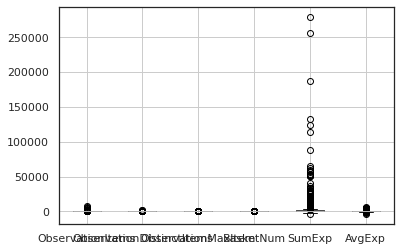

In [50]:
dataset_frame_customer.boxplot()

# Remove Outliers From The New Dataset

I exploited the metric of Z-Score.

In [52]:
z_scores = zscore(dataset_frame_customer)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_dataset_frame = dataset_frame_customer[filtered_entries]
new_dataset_frame.to_csv(r'Data/new_dataset.csv', index=True, header=True)
new_dataset_frame.describe()

,ObservationItems,ObservationDistinctItems,ObservationMaxItem,BasketNum,SumExp,AvgExp
count,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000,4158.000000
mean,71.440356,52.205147,28.607504,4.242665,1223.584777,281.482805
std,88.671079,53.796519,22.830264,4.682463,1793.110829,200.922765
min,1.000000,1.000000,1.000000,1.000000,-1165.300000,-611.860000
25%,17.000000,15.000000,12.000000,1.000000,279.812500,149.785000
50%,39.000000,33.000000,22.000000,3.000000,609.520000,230.555833
75%,92.000000,71.000000,39.000000,5.000000,1415.215000,355.347500
max,756.000000,316.000000,125.000000,33.000000,21086.300000,1395.795000


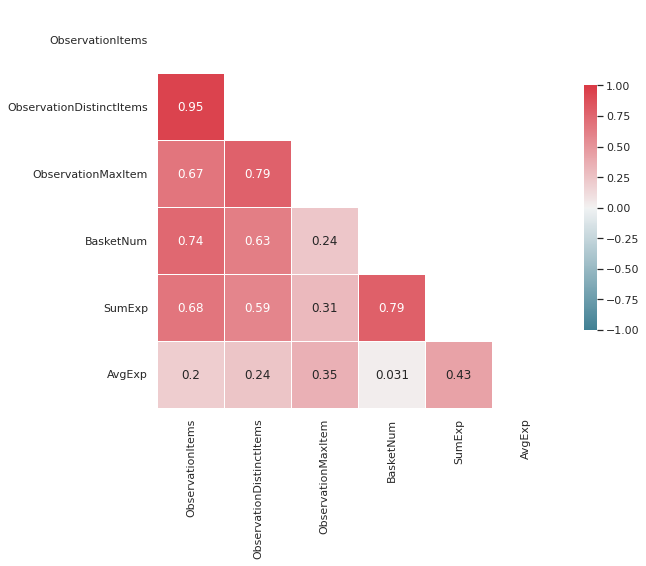

In [54]:
correlation = new_dataset_frame.corr()
sns.set(style="white")
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fnew, axnew = plt.subplots(figsize=(9,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap,annot=True, vmax=1,vmin=-1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})